In [ ]:
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Goa').text

In [4]:
soup = BeautifulSoup(source,'html.parser')
My_Table = soup.find('table',{'class':'wikitable plainrowheaders sortable'})

In [10]:
table_body = My_Table.find('tbody')
data=[]
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

In [11]:
data.pop(0)
data.pop(0)
column_names = ['Type','Taluka', 'Population','land_area_km','land_area_mi','District'] 
dftable = pd.DataFrame(data,columns=column_names)

In [12]:
dftable.head()

,Type,Taluka,Population,land_area_km,land_area_mi,District
0,City,Bicholim,16986,14.50,5.60,North Goa
1,City,Canacona,12434,18.70,7.22,South Goa
2,City,Salcete,16623,28.70,11.08,South Goa
3,City,Quepem,22730,22.60,8.73,South Goa
4,City,Bardez,40487,11.32,4.37,North Goa


In [13]:
dftable.drop(["Type","land_area_mi","land_area_km"], axis=1,inplace=True)

In [14]:
dftable

,Taluka,Population,District
0,Bicholim,16986,North Goa
1,Canacona,12434,South Goa
2,Salcete,16623,South Goa
3,Quepem,22730,South Goa
4,Bardez,40487,North Goa
5,Salcete,87650,South Goa
6,Mormugao,94393,South Goa
7,Tiswadi,40017,North Goa
8,Pernem,5289,North Goa
9,Ponda,22664,South Goa


In [15]:
citydata = pd.read_csv('Goa_City_Data.txt')

In [16]:
citydata.drop("Taluka", axis=1,inplace=True)

In [17]:
result = dftable.merge(citydata, left_index=True, right_index=True)

In [18]:
result.head()

,Taluka,Population,District,City
0,Bicholim,16986,North Goa,Bicholim
1,Canacona,12434,South Goa,Canacona
2,Salcete,16623,South Goa,Cuncolim
3,Quepem,22730,South Goa,Curchorem
4,Bardez,40487,North Goa,Mapusa


In [19]:
result1 = result.groupby(['Taluka'], sort=False).agg( ', '.join)

In [20]:
df2 =result1.reset_index() #reset index
df2.head(10)

,Taluka,Population,District,City
0,Bicholim,"16986, 13651","North Goa, North Goa","Bicholim, Sanquelim"
1,Canacona,12434,South Goa,Canacona
2,Salcete,"16623, 87650","South Goa, South Goa","Cuncolim, Margao"
3,Quepem,"22730, 14795","South Goa, South Goa","Curchorem, Quepem"
4,Bardez,40487,North Goa,Mapusa
5,Mormugao,94393,South Goa,Mormugao
6,Tiswadi,40017,North Goa,Panaji
7,Pernem,5289,North Goa,Pernem
8,Ponda,22664,South Goa,Ponda
9,Sanguem,6444,South Goa,Sanguem


In [21]:
df2.Taluka[1]

'Canacona'

### Convert an address into latitude and longitude values

In [22]:
latitude = []
longitude = []
for i in range(len(df2.City)):
    address = str(df2.City[i]+', '+ df2.Taluka[i] + ', Goa,India')
    geolocator = Nominatim(user_agent="goa_explorer")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    location = geolocator.geocode(address)
    try: 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append("Not Found")
        longitude.append("Not Found")
    
print('Done!')

Done!


In [23]:
latdata = pd.DataFrame(latitude,columns=['Latitude'])
londata = pd.DataFrame(longitude,columns=['Longitude'])

In [24]:
result1 = latdata.merge(londata, left_index=True, right_index=True)

In [25]:
result1

,Latitude,Longitude
0,Not Found,Not Found
1,15.0068,74.0395
2,15.2923,74.0069
3,15.2617,74.1083
4,15.5927,73.8118
5,15.4082,73.793
6,15.499,73.8282
7,15.709,73.8168
8,15.4004,74.0116
9,15.2277,74.142


In [26]:
result = df2.merge(result1, left_index=True, right_index=True)

In [27]:
result.head()

,Taluka,Population,District,City,Latitude,Longitude
0,Bicholim,"16986, 13651","North Goa, North Goa","Bicholim, Sanquelim",Not Found,Not Found
1,Canacona,12434,South Goa,Canacona,15.0068,74.0395
2,Salcete,"16623, 87650","South Goa, South Goa","Cuncolim, Margao",15.2923,74.0069
3,Quepem,"22730, 14795","South Goa, South Goa","Curchorem, Quepem",15.2617,74.1083
4,Bardez,40487,North Goa,Mapusa,15.5927,73.8118


In [29]:
result = result[result.Latitude != "Not Found"]
result

,Taluka,Population,District,City,Latitude,Longitude
1,Canacona,12434,South Goa,Canacona,15.0068,74.0395
2,Salcete,"16623, 87650","South Goa, South Goa","Cuncolim, Margao",15.2923,74.0069
3,Quepem,"22730, 14795","South Goa, South Goa","Curchorem, Quepem",15.2617,74.1083
4,Bardez,40487,North Goa,Mapusa,15.5927,73.8118
5,Mormugao,94393,South Goa,Mormugao,15.4082,73.793
6,Tiswadi,40017,North Goa,Panaji,15.499,73.8282
7,Pernem,5289,North Goa,Pernem,15.709,73.8168
8,Ponda,22664,South Goa,Ponda,15.4004,74.0116
9,Sanguem,6444,South Goa,Sanguem,15.2277,74.142


In [30]:
print('The dataframe has {} taluka and {} city.'.format(
        len(result['Taluka'].unique()),
        result.shape[0]
    )
)

The dataframe has 9 taluka and 9 city.


#### Getting the coordinates of Goa State

In [31]:
address = ' North Goa, India'

geolocator = Nominatim(user_agent="goa_explorer")
location = geolocator.geocode(address)
lat_e = location.latitude
long_e = location.longitude
print('The geograpical coordinate of Goa State are {}, {}.'.format(lat_e, long_e))

The geograpical coordinate of Goa State are 15.60444125, 74.00172406307475.


#### Creating a map of Goa with neighborhoods superimposed on top.

In [32]:
# create map of Goa using latitude and longitude values
map_goa = folium.Map(location=[lat_e, long_e], zoom_start=10)

# add markers to map
for lat, lng, taluka, city in zip(result['Latitude'], result['Longitude'], result['Taluka'], result['City']):
    label = '{}, {}'.format(city, taluka)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_goa)  
    
map_goa

#### Utilizing the Foursquare API to explore the neighborhoods and segment them¶
Defining Foursquare Credentials and Version

In [73]:
LIMIT = 200
CLIENT_ID = '####779FKZAXXSRDC0AEA0NZDT4OLDKF4LY###%%%' # your Foursquare ID
CLIENT_SECRET = '####R0RDKJ1CFNUOI%%%%' # your Foursquare Secret
VERSION = '20200208' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ####779FKZAXXSRDC0AEA0NZDT4OLDKF4LY###%%%
CLIENT_SECRET:####R0RDKJ1CFNUOI%%%%


Creating a dataframe with all the venues information provided by foursquare for the given latitude and longitude values

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the above function on each neighborhood and create a new dataframe called Goa_venues

In [37]:
Goa_venues = getNearbyVenues(names=result['City'],
                                   latitudes=result['Latitude'],
                                   longitudes=result['Longitude']
                                  )

Canacona
Cuncolim, Margao
Curchorem, Quepem
Mapusa
Mormugao
Panaji 
Pernem
Ponda
Sanguem


In [39]:
print(Goa_venues.shape)
Goa_venues

(84, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Canacona,15.006842,74.039489,Canacona Railway Station,15.006842,74.039379,Train Station
1,Canacona,15.006842,74.039489,Jasmine's Shack,15.005048,74.039935,Breakfast Spot
2,Canacona,15.006842,74.039489,Pai Chemist,15.008872,74.040630,Pharmacy
3,Canacona,15.006842,74.039489,Kadamba Bus Stand,15.008476,74.041817,Bus Station
4,"Cuncolim, Margao",15.292336,74.006904,HDFC Bank,15.290946,74.007448,ATM
...,...,...,...,...,...,...,...
79,Pernem,15.708996,73.816760,Mahalaxmi Bhojanalay (NH17),15.709986,73.813960,Seafood Restaurant
80,Ponda,15.400397,74.011610,St. Ana Bakery,15.401057,74.013129,Bakery
81,Ponda,15.400397,74.011610,Perfect Taste Fast Food,15.401699,74.011513,Fast Food Restaurant
82,Ponda,15.400397,74.011610,Ponda Fish Market,15.401696,74.008670,Fish Market


#### Extracting only restaurants from venue category list and creating a dataframe "Goa_restaurants"

In [40]:
Goa_restaurants = Goa_venues[Goa_venues['Venue Category'].str.contains("Restaurant")]

In [41]:
print('There are {} unique categories or cusines available in Goa.'.format(len(Goa_restaurants['Venue Category'].unique())))

There are 11 unique categories or cusines available in Goa.


#### Analysis of each neighborhood

In [42]:
# one hot encoding
Goa_onehot = pd.get_dummies(Goa_restaurants[['Venue Category']], prefix="", prefix_sep="")

In [43]:
Goa_onehot['Neighborhood'] = Goa_restaurants['Neighborhood'] 

In [44]:
# move neighborhood column to the first column
fixed_columns = [Goa_onehot.columns[-1]] + list(Goa_onehot.columns[:-1])
Goa_onehot = Goa_onehot[fixed_columns]

Goa_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Mughlai Restaurant,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant
20,Mapusa,0,0,0,0,0,0,0,0,1,0,0
29,Panaji,0,0,0,1,0,0,0,0,0,0,0
30,Panaji,0,0,0,0,1,0,0,0,0,0,0
32,Panaji,0,0,0,1,0,0,0,0,0,0,0
38,Panaji,0,1,0,0,0,0,0,0,0,0,0


In [45]:
print('There are {} restaurants in Goa with {} different style of cuisines.'.format(Goa_onehot.shape[0],(Goa_onehot.shape[1]-1)))

There are 19 restaurants in Goa with 11 different style of cuisines.


#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category/restaurants

In [46]:
Goa_grouped = Goa_onehot.groupby('Neighborhood').mean().reset_index()
Goa_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Mughlai Restaurant,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant
0,Mapusa,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.000,1.0000,0.0000,0.0000
1,Panaji,0.0625,0.0625,0.0,0.375,0.0625,0.0625,0.0625,0.125,0.0625,0.0625,0.0625
2,Pernem,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.000,1.0000,0.0000,0.0000
3,Ponda,0.0000,0.0000,1.0,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000


#### Top 3 restaurants for each Neighborhood based on cuisine

In [47]:
num_top_rest = 3

for hood in Goa_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Goa_grouped[Goa_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Mapusa----
                 venue  freq
0   Seafood Restaurant   1.0
1  American Restaurant   0.0
2     Asian Restaurant   0.0


----Panaji ----
                 venue  freq
0    Indian Restaurant  0.38
1           Restaurant  0.12
2  American Restaurant  0.06


----Pernem----
                 venue  freq
0   Seafood Restaurant   1.0
1  American Restaurant   0.0
2     Asian Restaurant   0.0


----Ponda----
                  venue  freq
0  Fast Food Restaurant   1.0
1   American Restaurant   0.0
2      Asian Restaurant   0.0




#### Creating a new dataframe with the above results for each neighborhood

In [48]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Goa_grouped['Neighborhood']


for ind in np.arange(Goa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Goa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mapusa,Seafood Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Fast Food Restaurant,Asian Restaurant
1,Panaji,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant
2,Pernem,Seafood Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Fast Food Restaurant,Asian Restaurant
3,Ponda,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Asian Restaurant


## Custering Neighborhoods using K-means
#### Finding the best k

In [50]:
# Creating new dataframe to determine best k value by dropping first column
Goa_clustering_testing = Goa_grouped.drop('Neighborhood', 1)

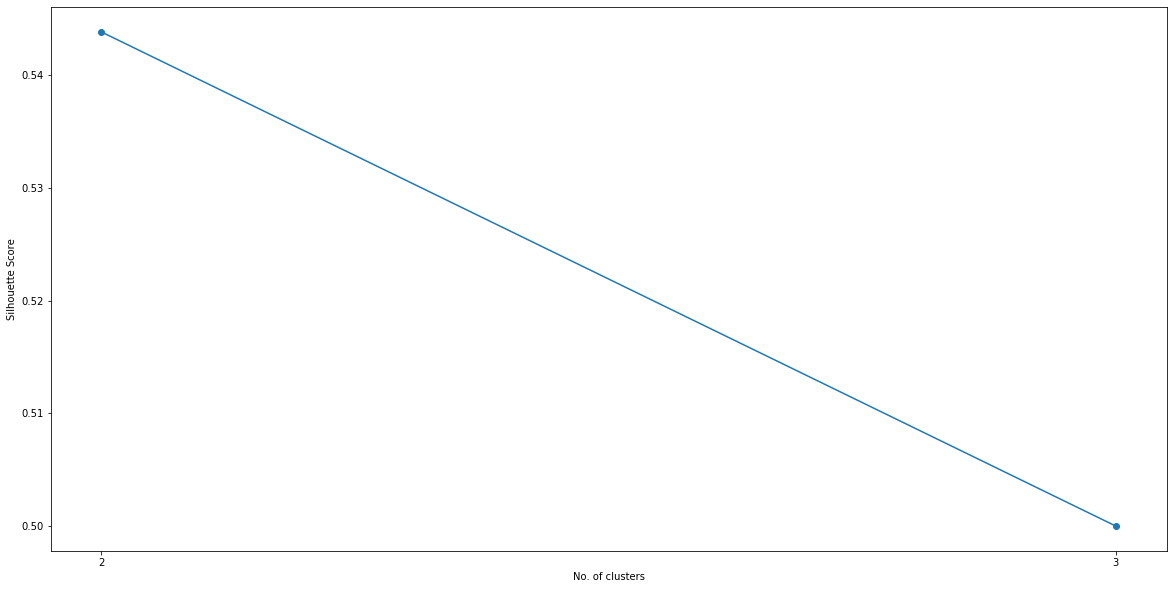

In [51]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 4

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = Goa_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

#### From the graph the optimal number is found out to be considered for our clustering

In [52]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

2

In [53]:
# set number of clusters
kclusters = opt

Goa_grouped_clustering = Goa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Goa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 0], dtype=int32)

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [54]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Goa_merged = Goa_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Goa_merged = Goa_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Goa_merged.fillna(0)
Goa_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Mapusa,15.592674,73.811762,Kamlabai Restaurant,15.591089,73.808934,Seafood Restaurant,1,Seafood Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Fast Food Restaurant,Asian Restaurant
29,Panaji,15.498995,73.828214,Ritz Classic Family Restaurant,15.498470,73.826742,Indian Restaurant,0,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant
30,Panaji,15.498995,73.828214,Delhi Darbar,15.500507,73.827109,Mughlai Restaurant,0,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant
32,Panaji,15.498995,73.828214,George Bar & Restaurant,15.498843,73.828720,Indian Restaurant,0,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant
38,Panaji,15.498995,73.828214,Goenchin,15.496678,73.827239,Asian Restaurant,0,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant


#### Number of venues belonging to each cluster

In [55]:
Goa_merged['Cluster Labels'].value_counts()

0    17
1     2
Name: Cluster Labels, dtype: int64

#### Creating map for each cluster for better visualization

In [67]:
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=10)
count=0
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, vc in zip(Goa_merged['Venue Latitude'], Goa_merged['Venue Longitude'], Goa_merged['Venue'], Goa_merged['Cluster Labels'], Goa_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Final analysis of each cluster
Now, examining each cluster and determining the discriminating restaurants that distinguish each cluster. Based on the restaurants, we can then assign a name to each cluster.

#### Cluster 1

In [68]:
c1 = Goa_merged.loc[Goa_merged['Cluster Labels'] == 0, Goa_merged.columns[[0]+list(range(8, Goa_merged.shape[1]))]]
c1.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Panaji,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Asian Restaurant,American Restaurant
81,Ponda,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Asian Restaurant


#### Cluster 2

In [69]:
c2 = Goa_merged.loc[Goa_merged['Cluster Labels'] == 1, Goa_merged.columns[[0]+list(range(8, Goa_merged.shape[1]))]]
c2.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Mapusa,Seafood Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Fast Food Restaurant,Asian Restaurant
79,Pernem,Seafood Restaurant,Vegetarian / Vegan Restaurant,Southern / Soul Food Restaurant,Restaurant,Punjabi Restaurant,Portuguese Restaurant,Mughlai Restaurant,Indian Restaurant,Fast Food Restaurant,Asian Restaurant


In [70]:

c1_table = Goa_merged.loc[Goa_merged['Cluster Labels'] == 0, Goa_merged.columns[[0]+[3]+[4]+[5]+list(range(8, Goa_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

In [72]:
c1_table = Goa_merged.loc[Goa_merged['Cluster Labels'] == 1, Goa_merged.columns[[0]+[3]+[4]+[5]+list(range(8, Goa_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat_e, long_e], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Results

|Cluster|Most Common Restaurant|
|-------|----------------------|
|  1    |  Indian and Fast Food|
|  2    |    SeaFood           |

#### Discussion
The results can be approached in two ways;

1.If company want to open a restaurant in preferred location and irrespective of cuisine, refer to that neighborhood in specific cluster and chose cuisine with the least common restaurant for better profits
2.If company wants to open a restaurant with a preferred cuisine and irrespective of location, refer to the cluster with the least number of restaurants with that specific cuisine and select one among the neighborhoods based on company’s preference.

#### Conclusion

This analysis is performed on limited data. This may be right or may be wrong. But if good amount of data is available there is scope to come up with better results. If there are lot of restaurants probably there is lot of demand. Goa has so many restaurants, yet certain neighborhood or taluka doesn’t have a specific cuisine restaurant available. 